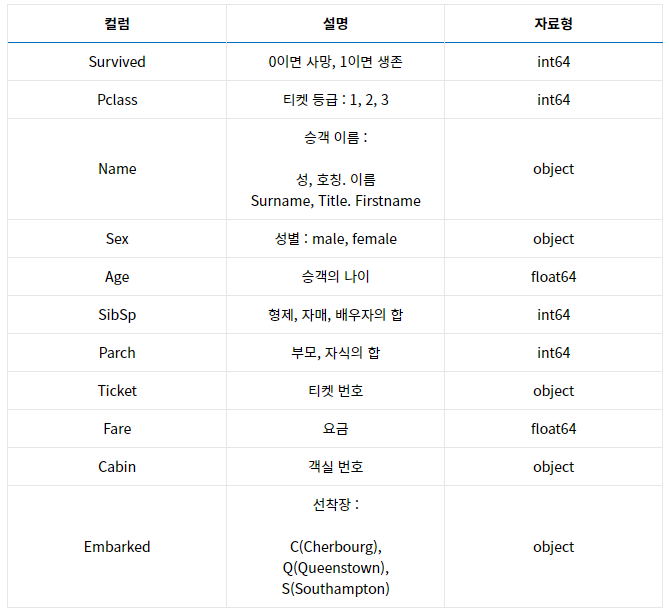



#**데이터 준비**

In [519]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('fivethirtyeight')

In [520]:
train=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AI_Lecture/titanic/train.csv", index_col='PassengerId')
test=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AI_Lecture/titanic/test.csv", index_col='PassengerId')
submission=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AI_Lecture/titanic/gender_submission.csv", index_col='PassengerId')

train, test 데이터 불러오는데 PassengerId가 고유값이므로 index로 사용하여 불러옴

------------------------------------------------------------
------------------------------------------------------------

#**데이터 변수 확인**

In [521]:
train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [522]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [523]:
train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Embarked의 경우 패딩하여 사용하겠지만 결측치가 너무 많은 Cabin의 경우 사용하지 않는게 좋을 것 이라 예상

In [524]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Danbom, Mr. Ernst Gilbert",male,347082,B96 B98,S
freq,1,577,7,4,644


Name은 miss, mr 처럼 결혼 여부 등의 정보가 들어있으니 변형해서 사용해야할듯

Sex는 male이 577로 많음

Ticket, Cabin은 의미 없는 고유값일듯..

Embarked는 승객의 대다수인 644명이 S에서 탑승

In [525]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200



Survived => 생존률 38%?

Age => 2~30대 승객 다수

SibSp, Parch 비슷한 성격의 변수, 대부분 승객이 홀로탐

Fare => 평균은 32이나 max값이 512이므로 최대치를 낮게 조정해줄 필요가 있음

------------------------------------------------------------
------------------------------------------------------------

## **탐색적 데이터 분석**

변수들의 관계를 분석하고 시각화를 통해 변수 엔지니어링

**0. 생존률(Survived)**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


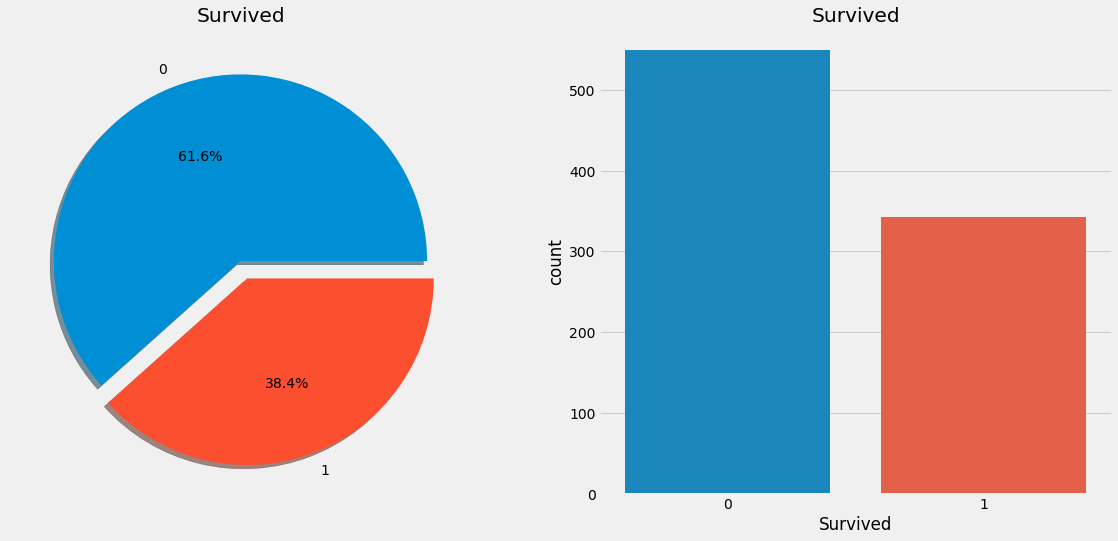

In [526]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

train['Survived'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot('Survived', data=train, ax=ax[1])
ax[1].set_title('Survived')
plt.show()

pandas의 plot.pie, seaborn을 이용한 Survived 비율 분석 => 생존하지 못한 사람이 많음

**1. 성별(Sex)**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


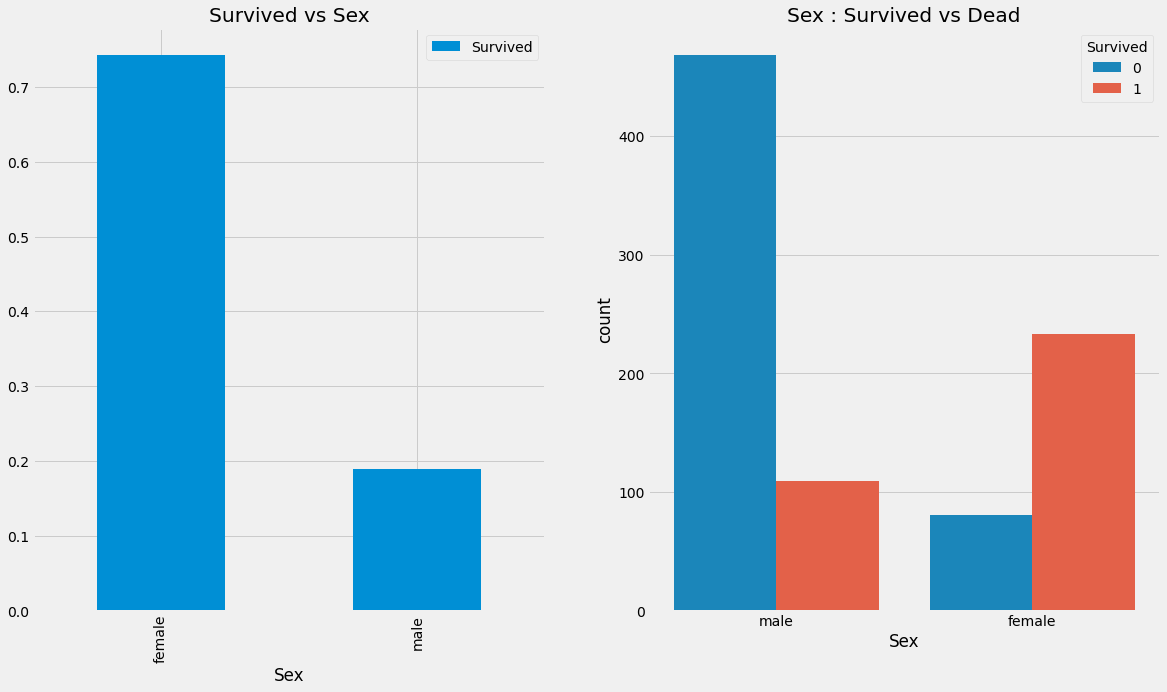

In [527]:
f, ax = plt.subplots(1,2, figsize=(18,10))
train[['Sex', 'Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot('Sex', hue='Survived', data=train, ax=ax[1])
ax[1].set_title('Sex : Survived vs Dead')
plt.show()

여성이 남성보다 생존률 훨신 높음

**2. 객실 등급(Pclass)**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


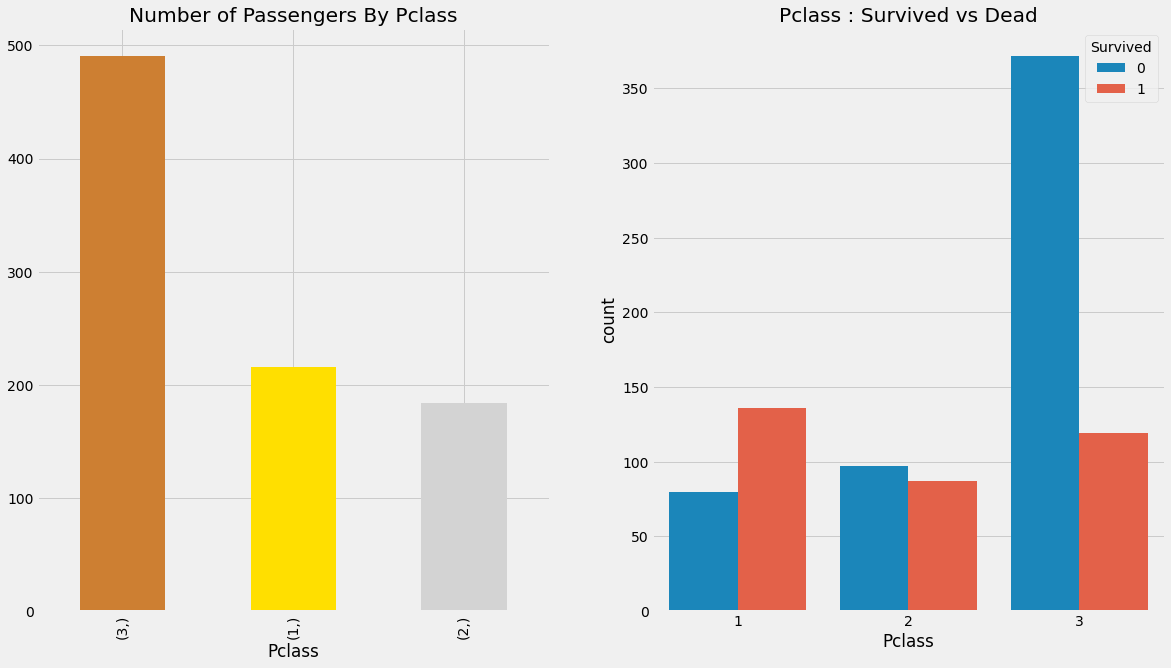

In [528]:
f, ax = plt.subplots(1,2, figsize=(18,10))
train[['Pclass']].value_counts().plot.bar(color=['#CD7F32', '#FFDF00', '#D3D3D3'], ax=ax[0])
ax[0].set_title('Number of Passengers By Pclass')
sns.countplot('Pclass', hue='Survived', data=train, ax=ax[1])
ax[1].set_title('Pclass : Survived vs Dead')
plt.show()

3 > 1 > 2등석으로 탑승한 인원이 많았고,

1 > 2 > 3등석으로 생존 비율이 높았다.

3. 동반 형재 자매(SibSp)

   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000


Text(0.5, 0, 'SibSp')

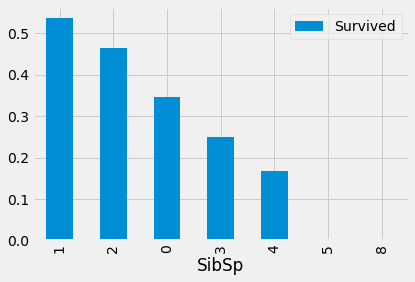

In [529]:
sibsp_data=train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)
print(sibsp_data)
sibsp_data.plot("SibSp",kind="bar").set_xlabel("SibSp")

동승한 형제 및 배우자 수가 1 or 2명일 때 생존률이 높으며, 이후 03456순

**4. 동반 부모, 자녀(Parch)**

   Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.500000
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000


Text(0.5, 0, 'Parch')

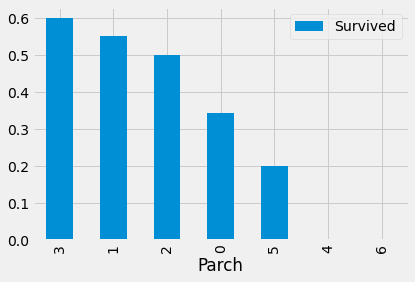

In [530]:
parch_data=train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)
print(parch_data)
parch_data.plot("Parch",kind="bar").set_xlabel("Parch")

동승한 부모 자식 수가 적을수록 (3120546 순)으로 생존률이 높음

sibsp, parch를 합친 변수를 통해 분석한다면 다른 결과가 나올까?

**5. 승선 항(Embarked)**

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957


Text(0.5, 0, 'Embarked')

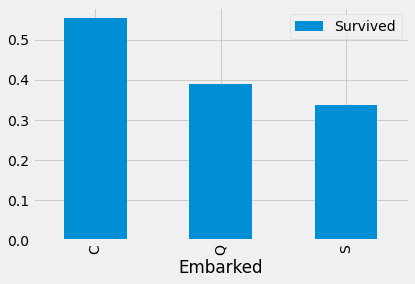

In [531]:
embarked_data=train[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)
print(embarked_data)
embarked_data.plot("Embarked",kind="bar").set_xlabel("Embarked")

CQS 순으로 생존률을 보임

6. 나이(Age)

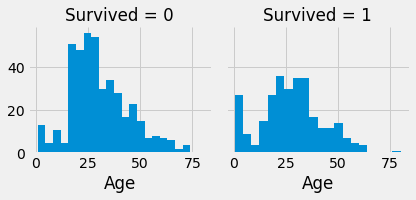

In [532]:
age_data = sns.FacetGrid(train, col='Survived')
age_data.map(plt.hist, 'Age', bins=20)

4세 이하 생존율 높음

15~25 생존율 높음

나이에 결측치(NULL)이 존재하고 연속 데이터이므로 변형 필요


7. 요금(Fare)

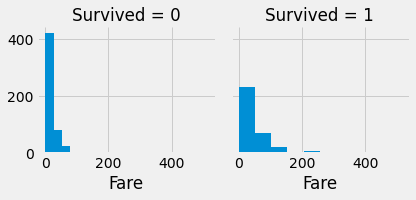

In [533]:
fare_data = sns.FacetGrid(train, col='Survived')
fare_data.map(plt.hist, 'Fare', bins=10)

높은 요금이 생존하는건 아닌듯?

결측치 존재하고 연속 데이터이므로 변형 필요

**- 객실등급 && 생존여부에 따른 나이 분포**

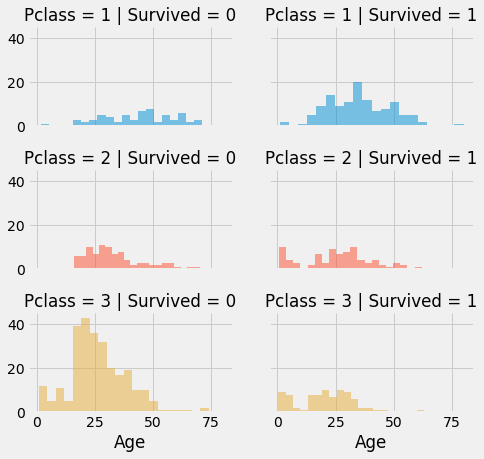

In [534]:
grid = sns.FacetGrid(train, col='Survived', row='Pclass', hue="Pclass", height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)

Pclass가 3등급일 경우 승객이 가장 많고 생존률 가장 낮음

Pclass 2등급에서 유아들은 대부분 생존

Pclass 1등급에서 생존률이 비교적 높음

**낮은 객실에서 대부분 사망하지만 어린 나이의 승객들 생존**

**- 승선항 && 객실등급에 따른 생존률**

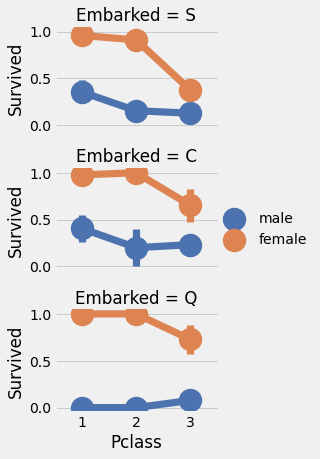

In [535]:
grid = sns.FacetGrid(train, row='Embarked', height=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep', order = [1, 2, 3], hue_order = ["male", "female"])
grid.add_legend()

Q 남성 생존 낮고, C,Q에서 남성 3등급이 2등급보다 생존률 높은 가능성 있음

**- 승선항 && 생존여부 && 성별에 따른 요금**

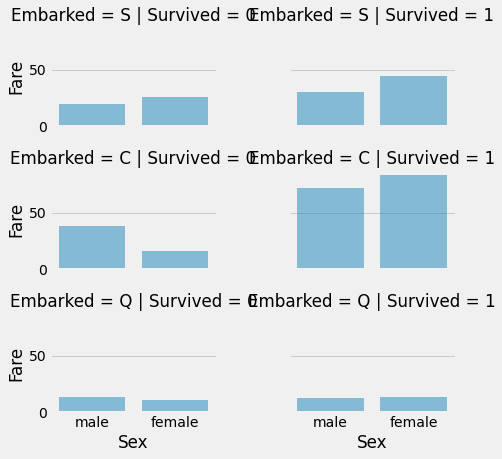

In [536]:
grid = sns.FacetGrid(train, row='Embarked', col='Survived', height=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None,order=["male","female"])

승선지가 S또는 C인 경우, 생존한 승객들의 평균 요금이 비교적 높음

-----------------------------------------------------------
------------------------------------------------------------

## Feature Engineering

In [537]:
train=train.drop(columns='Cabin')
test=test.drop(columns='Cabin')
train=train.drop(columns='Ticket')
test=test.drop(columns='Ticket')
train=train.drop(columns='Age')
test=test.drop(columns='Age')

고유값이라 안쓰는 Cabin, Ticket 변수 드롭

Cabin은 결측지도 너무 많음..

Age 또한 밴드로 나눠 요거저거 해봤으나 성능 저하로 드롭

In [538]:
train.loc[train['Sex']=='male', 'Sex']=0
train.loc[train['Sex']=='female','Sex']=1
test.loc[test['Sex']=='male','Sex']=0
test.loc[test['Sex']=='female','Sex']=1

성별은 male & female로 되어 있던 data를 numeric하게 바꿔줌



In [539]:
train['Pclass_3']=(train['Pclass']==3)
train['Pclass_2']=(train['Pclass']==2)
train['Pclass_1']=(train['Pclass']==1)

test['Pclass_3']=(test['Pclass']==3)
test['Pclass_2']=(test['Pclass']==2)
test['Pclass_1']=(test['Pclass']==1)

train=train.drop(columns='Pclass')
test=test.drop(columns='Pclass')

Pclass에 따라 각각의 변수로 원핫인코딩

In [540]:
train.loc[train['Fare'].isnull(),'Fare']=0
test.loc[test['Fare'].isnull(),'Fare']=0

Fare 결측치 0으로 패딩

밴드로 나눠 시도해봤으나 좋은 결과가 나오지 않았음..

In [541]:
train['FamilySize']=train['SibSp']+train['Parch']+1
test['FamilySize']=test['SibSp']+test['Parch']+1

In [542]:
train['Single']=train['FamilySize']==1
train['Mid']=(2<=train['FamilySize']) & (train['FamilySize']<=4)
train['Big']=train['FamilySize']>=5

test['Single']=test['FamilySize']==1
test['Mid']=(2<=test['FamilySize']) & (test['FamilySize']<=4)
test['Big']=test['FamilySize']>=5

In [543]:
train=train.drop(columns=['Single','Big','SibSp','Parch','FamilySize'])
test=test.drop(columns=['Single','Big','SibSp','Parch','FamilySize'])

앞서 예측에서 2~4인의 가족 형태에서 생존률이 높았으므로 변수 추가하고 나머지 드롭

sigle big 변수도 사용해봤으나 변화가 없었음

In [544]:
train['EmbarkedC']=train['Embarked']=='C'
train['EmbarkedS']=train['Embarked']=='S'
train['EmbarkedQ']=train['Embarked']=='Q'
test['EmbarkedC']=test['Embarked']=='C'
test['EmbarkedS']=test['Embarked']=='S'
test['EmbarkedQ']=test['Embarked']=='Q'

train=train.drop(columns='Embarked')
test=test.drop(columns='Embarked')

승선 항 원핫인코딩

In [545]:
train['Rename'] = train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test['Rename'] = test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

train['Rename'] = train['Rename'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')

train['Rename'] = train['Rename'].replace('Mlle', 'Miss')
train['Rename'] = train['Rename'].replace('Ms', 'Miss')
train['Rename'] = train['Rename'].replace('Mme', 'Mrs')

test['Rename'] = test['Rename'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')

test['Rename'] = test['Rename'].replace('Mlle', 'Miss')
test['Rename'] = test['Rename'].replace('Ms', 'Miss')
test['Rename'] = test['Rename'].replace('Mme', 'Mrs')

train['Rename_Numeric'] = train['Rename'].astype('category').cat.codes
test['Rename_Numeric'] = test['Rename'].astype('category').cat.codes


train=train.drop(columns='Name')
test=test.drop(columns='Name')
train=train.drop(columns='Rename')
test=test.drop(columns='Rename')

수가 별로 없는 이름 데이터들은 단일화시켜 이름 5가지로 줄이고 Numeric하게 바꿔줌

In [516]:
Y_train=train['Survived']
feature=list(test)
X_train=train[feature]
X_test=test[feature]

In [517]:
from sklearn.tree import DecisionTreeClassifier

model=DecisionTreeClassifier(max_depth=11, random_state=18)
model.fit(X_train, Y_train)
predictions=model.predict(X_test)
submission['Survived']=predictions
submission.to_csv('Submit.csv')
submission.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


In [518]:
model.score(X_train, Y_train)

0.9135802469135802

캐글 결과랑 차이나는 것 보니 오버피팅 발생한듯